# <center>Machine Learning Project - Ad Budget Estimation
#### <center> ***Domain: Marketing***

### Description:
The advertising dataset captures the sales revenue generated with respect to advertisement costs across multiple channels like radio, tv, and newspapers. 

It is required to understand the impact of ad budgets on the overall sales.

# <center>1. Data Exploration

In [2]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Importing the dataset

df = pd.read_csv('datasets/Advertising Budget and Sales.csv', index_col=0, names=['TV','Radio','Newspaper','Sales'], skiprows=1)

#df.drop([''], axis=1, inplace=True)
display(df.head())

target = 'Sales'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9



Inference: The Datset consists of 4 features & 200 samples.


In [4]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [5]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Sales        121
Radio        167
Newspaper    172
TV           190
dtype: int64

In [6]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 3 numerical & 0 categorical features.


In [7]:
#Checking the stats of all the columns

display(df.describe())

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


**Inference:** The stats seem to be fine, let us do further analysis on the Dataset

---

# <center> 2. Exploratory Data Analysis (EDA)

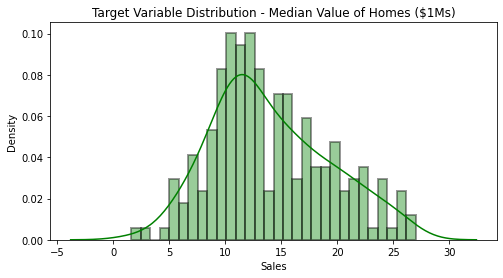

In [8]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

**Inference:**The Target Variable seems to be be normally distributed, averaging around $12(units)

In [9]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                               Visualising Categorical Features:                                


<Figure size 1080x0 with 0 Axes>

**Inference:** There are no categorical features in the dataset.

                                                Numeric Features Distribution                                                 


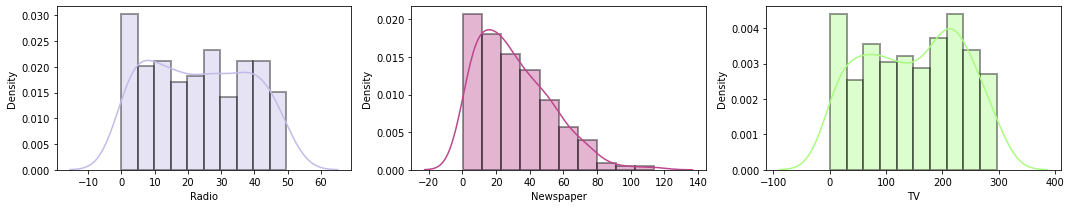

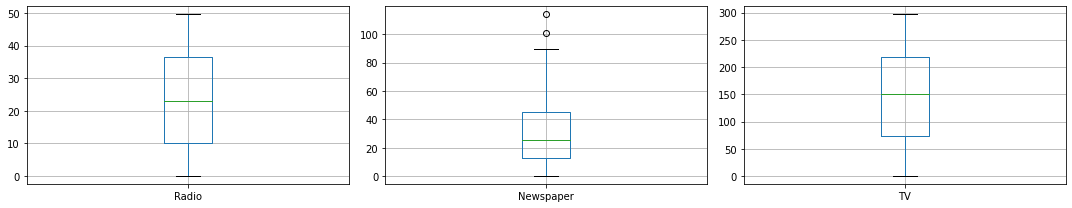

In [10]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(130))

n=3

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

**Inference:** There seem to be some outliers. let us fix these in the upcoming section...

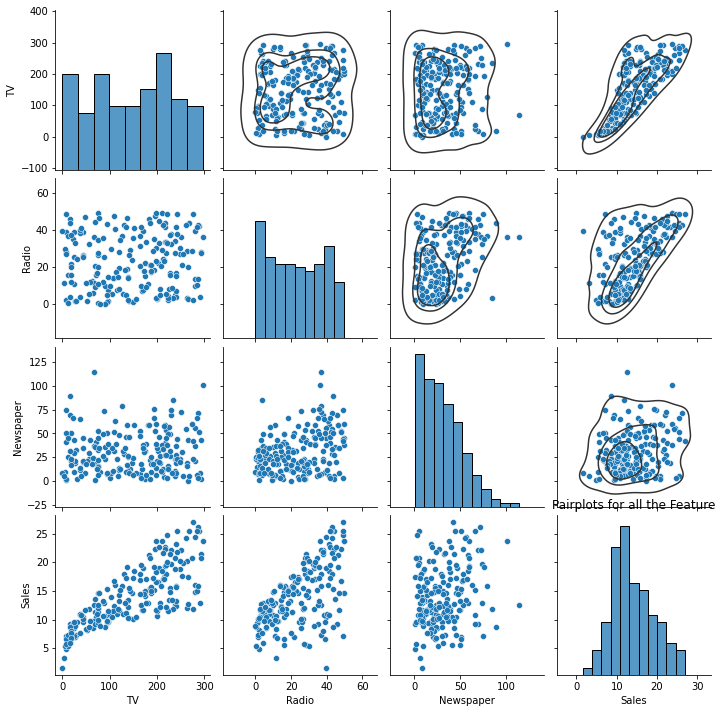

In [11]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

**Inference:** We can notice that some features have linear relationship, let us futher analyze the detect multicollinearity.

---

# <center> 3. Data Preprocessing

In [12]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [13]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

           Total Null Values  Percentage
TV                         0         0.0
Radio                      0         0.0
Newspaper                  0         0.0
Sales                      0         0.0


**Inference:** The datset doesn't have any inconsistant values.

In [14]:
#Converting categorical Columns to Numeric

df1 = df.copy()
df3 = df1.copy()

In [18]:
#Removal of outlier:

df1 = df3.copy()
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9



Inference:
Before removal of outliers, The dataset had 200 samples.
After removal of outliers, The dataset now has 198 samples.


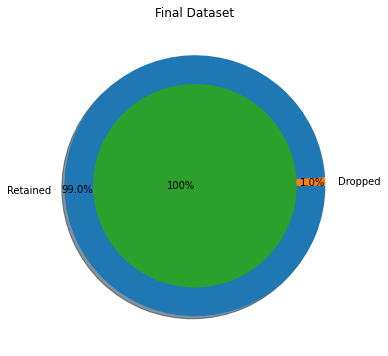


Inference: After the cleanup process, 2 samples were dropped, while retaining 1.0% of the data.


In [19]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

---

# <center> 4. Data Manipulation

In [20]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (198, 3) (198,) 
Training set  --->  (158, 3) (158,) 
Testing set   --->  (40, 3)  (40,)


In [21]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,TV,Radio,Newspaper
count,1.580000e+02,1.580000e+02,1.580000e+02
mean,1.208597e-16,-1.447506e-16,-1.826949e-17
std,1.003180e+00,1.003180e+00,1.003180e+00
min,-1.662355e+00,-1.503915e+00,-1.518214e+00
25%,-8.650507e-01,-8.896291e-01,-7.818344e-01
50%,-4.306958e-02,-6.888944e-02,-2.049415e-01
75%,8.793825e-01,8.381548e-01,6.846946e-01
max,1.693726e+00,1.833196e+00,2.892587e+00



                                          Standardardization on Testing set                                          


,TV,Radio,Newspaper
count,40.000000,40.000000,40.000000
mean,-0.120802,0.205424,-0.390968
std,1.014382,1.013117,1.033937
min,-1.739911,-1.524222,-1.548118
25%,-0.998424,-0.739019,-1.168091
50%,0.192538,0.140949,-0.740717
75%,0.690192,1.120760,0.196267
max,1.701951,1.792582,2.384224


---

# <center> 5. Feature Selection/Extraction

                 Correlation Matrix                


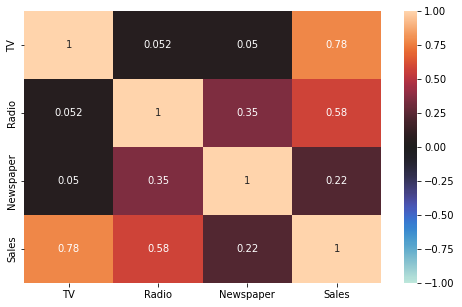

In [22]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(55))
plt.figure(figsize=[8,5])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

**Inference:** There seems to be strong multi-correlation between the features. Let us try to fix these...

In [23]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     487.1
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           2.39e-78
Time:                        11:40:38   Log-Likelihood:                -293.76
No. Observations:                 158   AIC:                             595.5
Df Residuals:                     154   BIC:                             607.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.0006      0.125    111.865      0.000      13.753      14.248
TV             3.6964      0.125     29.502      0.000       3.449       3.944
Radio          2.9466      0.138     21.365      0.000       2.674       3.219
Newspaper     -0.1928      0.138     -1.400      0.164      -0.465       0.079
==============================================================================
Omnibus:                       17.449   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.654
Skew:                          -0.827   Prob(JB):                     5.40e-05
Kurtosis:                       3.498   Cond. No.                         1.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 ---

**Approach:** 
We can fix these multicollinearity with two techniques:
1. Manual Method - Variance Inflation Factor (VIF)
2. Automatic Method - Recursive Feature Elimination (RFE)
3. Feature Elmination using PCA Decomposition

## 5a. Manual Method - VIF

Dropped Features -->  ['Radio']


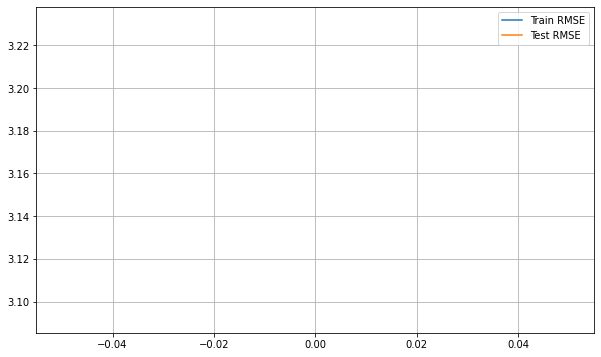

In [24]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

print('Dropped Features --> ',DROP)

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

## 5b. Automatic Method - RFE

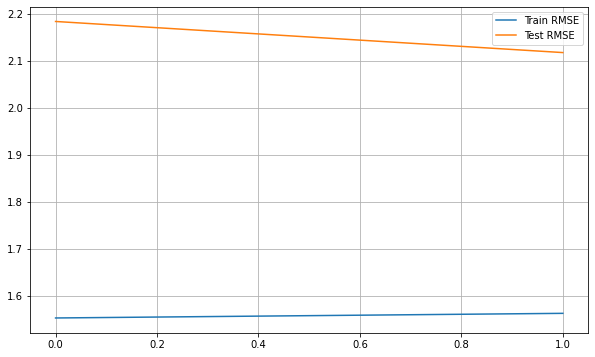

In [25]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()

    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)
    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

## 5c. Feature Elmination using PCA Decomposition

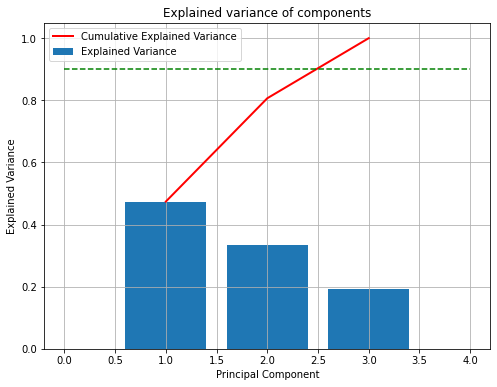

In [26]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

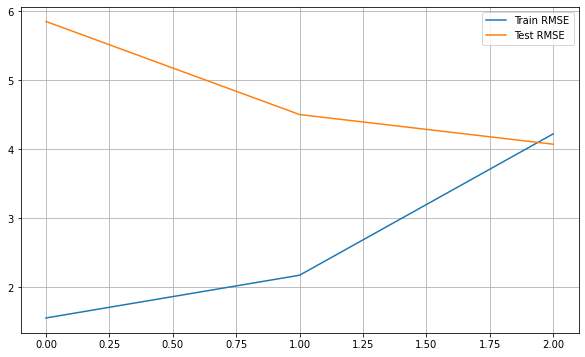

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

#### Inference:
It can be seen that the performance of the modelsis quiet comparable unpon dropping features using VIF, RFE & PCA Techniques. Comparing the RMSE plots, the optimal values were found for dropping most  features using manual RFE Technique.

---

# <center> 6. Predictive Modelling

In [29]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.columns,2)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

---

**Objective:** Let us now try building multiple regression models & compare their evaluation metrics to choose the best fit model both training and testing sets...

## 6a. Multiple Linear Regression(MLR)

<<<-------------------- Evaluating Multiple Linear Regression Model -------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.69637815  2.94662484 -0.19283051]
The Intercept of the Regresion Model was found to be  14.000632911392405


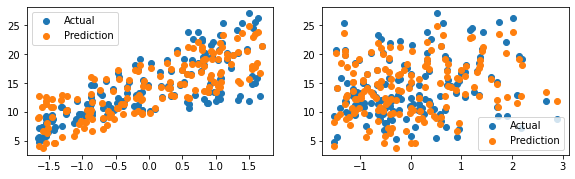



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9046635059559758
Residual Sum of Squares (RSS) on Training set  ---> 381.14099667994697
Mean Squared Error (MSE) on Training set       ---> 2.4122847891135883
Root Mean Squared Error (RMSE) on Training set ---> 1.5531531763202198

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.8556177767066229
Residual Sum of Squares (RSS) on Training set  ---> 190.68989767470617
Mean Squared Error (MSE) on Training set       ---> 4.767247441867654
Root Mean Squared Error (RMSE) on Training set ---> 2.183402720953616

--------------------Residual Plots--------------------


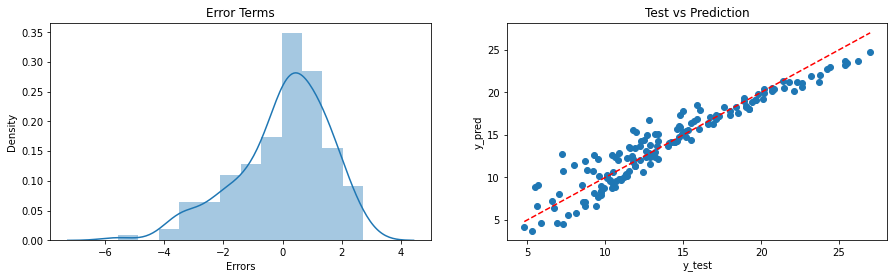

In [30]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*20,'-'*20,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

---

## 6b. Ridge Regression Model

<<<-------------------- Evaluating Ridge Regression Model -------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.69637815  2.94662484 -0.19283051]
The Intercept of the Regresion Model was found to be  14.000632911392405


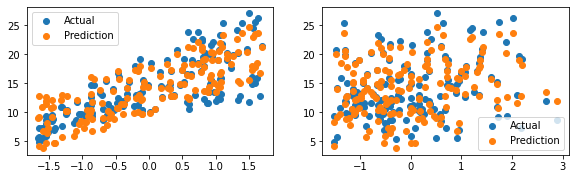



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9046264664952751
Residual Sum of Squares (RSS) on Training set  ---> 381.2890748855642
Mean Squared Error (MSE) on Training set       ---> 2.413221992946609
Root Mean Squared Error (RMSE) on Training set ---> 1.5534548570675006

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.8553280806292756
Residual Sum of Squares (RSS) on Training set  ---> 191.07250790251712
Mean Squared Error (MSE) on Training set       ---> 4.776812697562927
Root Mean Squared Error (RMSE) on Training set ---> 2.185592070255318

--------------------Residual Plots--------------------


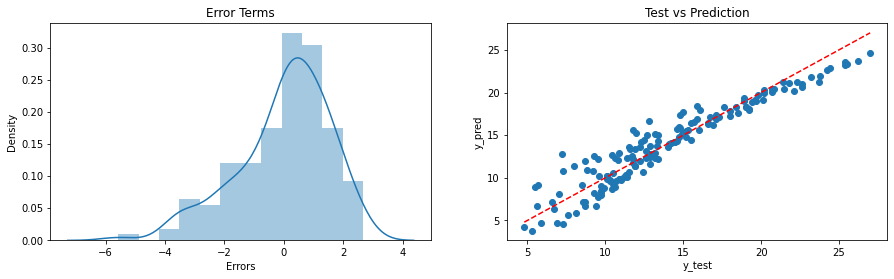

In [31]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*20,'-'*20,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

---

## 6c. Lasso Regression Model

<<<-------------------- Evaluating Lasso Regression Model -------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.69637815  2.94662484 -0.19283051]
The Intercept of the Regresion Model was found to be  14.000632911392405


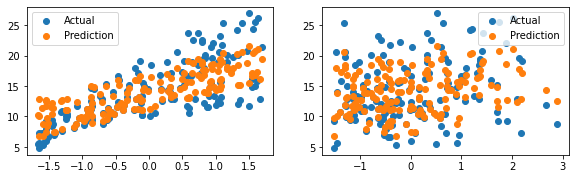



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.8278673741198022
Residual Sum of Squares (RSS) on Training set  ---> 688.1604074806787
Mean Squared Error (MSE) on Training set       ---> 4.355445616966321
Root Mean Squared Error (RMSE) on Training set ---> 2.086970439888002

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.7730203619051653
Residual Sum of Squares (RSS) on Training set  ---> 299.7787606760816
Mean Squared Error (MSE) on Training set       ---> 7.49446901690204
Root Mean Squared Error (RMSE) on Training set ---> 2.7376027865455645

--------------------Residual Plots--------------------


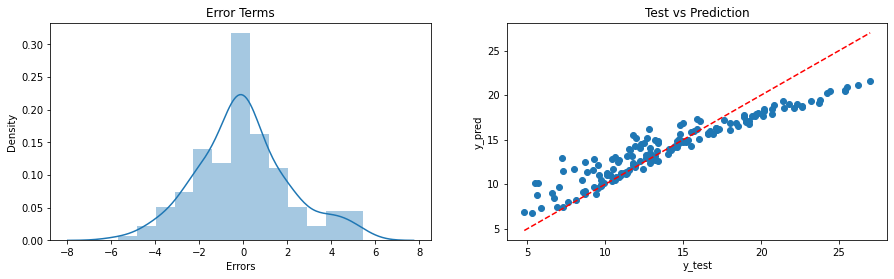

In [32]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*20,'-'*20,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

---

## 6d. Elastic-Net Regression

<<<-------------------- Evaluating Elastic-Net Regression Model -------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.69637815  2.94662484 -0.19283051]
The Intercept of the Regresion Model was found to be  14.000632911392405


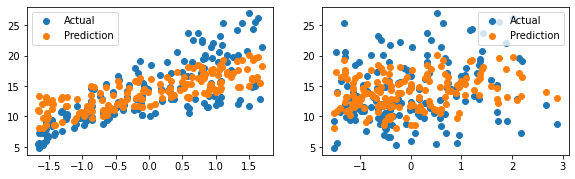



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.7433268395138777
Residual Sum of Squares (RSS) on Training set  ---> 1026.1407784043072
Mean Squared Error (MSE) on Training set       ---> 6.4945618886348555
Root Mean Squared Error (RMSE) on Training set ---> 2.548443032252213

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.6800469571269883
Residual Sum of Squares (RSS) on Training set  ---> 422.5715023254121
Mean Squared Error (MSE) on Training set       ---> 10.564287558135302
Root Mean Squared Error (RMSE) on Training set ---> 3.250274997309505

--------------------Residual Plots--------------------


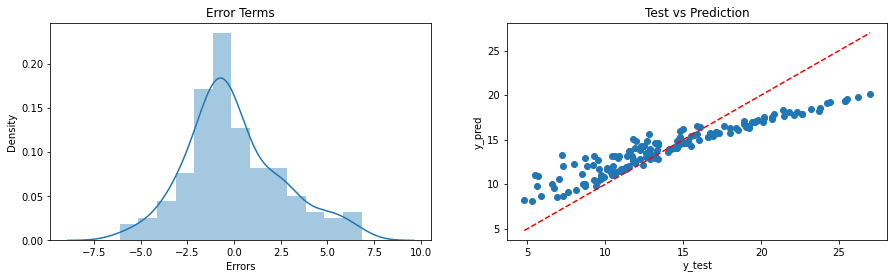

In [33]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*20,'-'*20,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

---

## 6e. Polynomial Regression Model

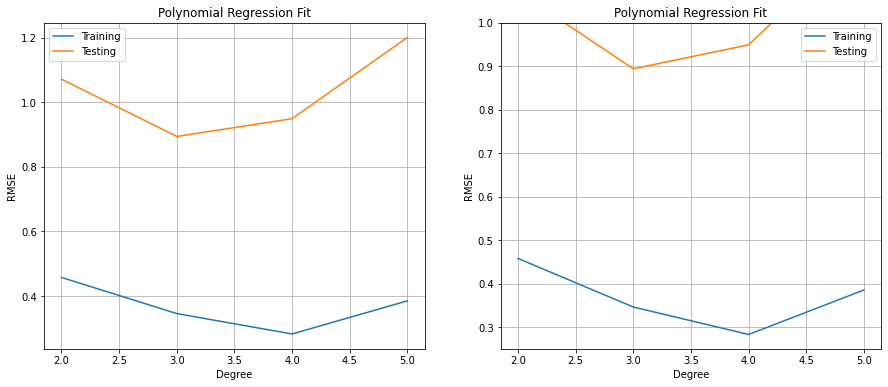

In [34]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=6

for i in range(2,n_degree):
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0.25,1])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

**Inference:** We can choose 2nd order polynomial regression as it gives the optimal training & testing scores...

<<<-------------------- Evaluating Polynomial Regression Model -------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.69637815  2.94662484 -0.19283051]
The Intercept of the Regresion Model was found to be  14.000632911392405


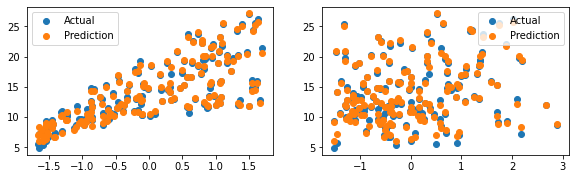



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9917189130237828
Residual Sum of Squares (RSS) on Training set  ---> 33.106543043751074
Mean Squared Error (MSE) on Training set       ---> 0.20953508255538655
Root Mean Squared Error (RMSE) on Training set ---> 0.45775002190648395

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9652533223582987
Residual Sum of Squares (RSS) on Training set  ---> 45.89097087505486
Mean Squared Error (MSE) on Training set       ---> 1.1472742718763715
Root Mean Squared Error (RMSE) on Training set ---> 1.0711088982341486

--------------------Residual Plots--------------------


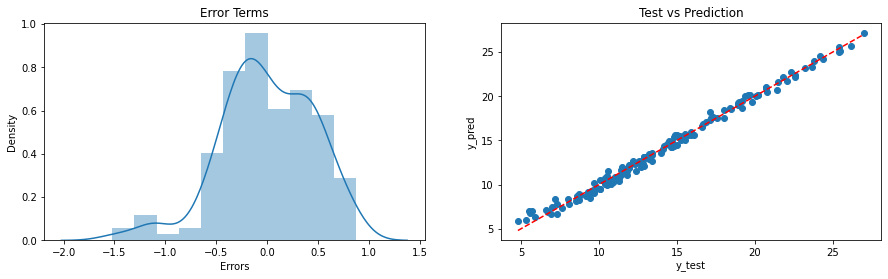

In [35]:
#Using the 2rd Order Polynomial Regression model (degree=3)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*20,'-'*20,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

---

### 6f. Comparing the Evaluation Metics of the Models

In [36]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.904664,0.855618,381.140997,190.689898,2.412285,4.767247,1.553153,2.183403
Ridge Linear Regression (RLR),0.904626,0.855328,381.289075,191.072508,2.413222,4.776813,1.553455,2.185592
Lasso Linear Regression (LLR),0.827867,0.773020,688.160407,299.778761,4.355446,7.494469,2.086970,2.737603
Elastic-Net Regression (ENR),0.743327,0.680047,1026.140778,422.571502,6.494562,10.564288,2.548443,3.250275
Polynomial Regression (PNR),0.991719,0.965253,33.106543,45.890971,0.209535,1.147274,0.457750,1.071109


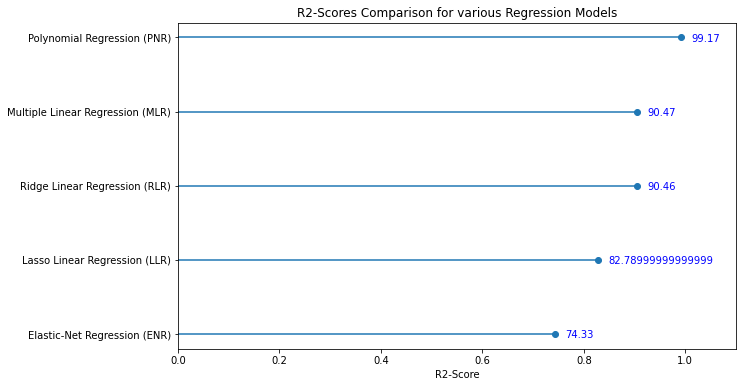

In [37]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

**Inference:** From the above plot, it is clear that the polynomial regresion models have the highest explainability power  to understand the dataset.

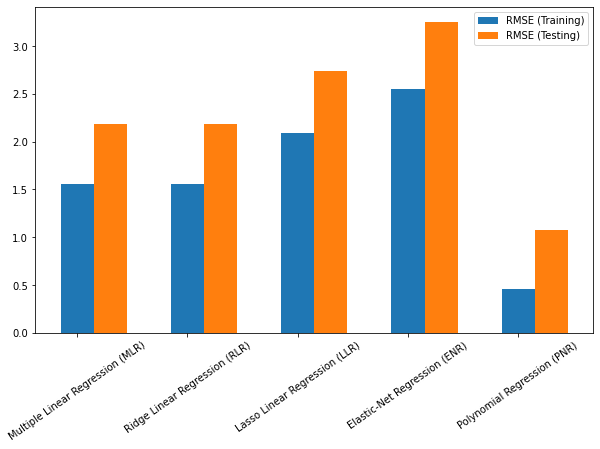

In [38]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.show()

**Inference:**\
Lesser the RMSE, better the model! Also, provided the model should have close proximity with the training & testing scores. For this problem, it is can be said that polynomial regressions are the best choice to go with.

In [39]:
#<<<--------------------------------------------THE END------------------------------------------------>>>